# Sentiment and Thematic Analysis

Importing important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import pipeline

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import spacy
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



/Users/elbethelzewdie/Documents/customers-satisfaction-week2/customers-satisfaction-week2/week2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/Users/elbethelzewdie/Documents/customers-satisfaction-week2/customers-satisfaction-week2/notebooks/data/processed/reviews_processed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623 entries, 0 to 1622
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    1623 non-null   object
 1   review_text  1623 non-null   object
 2   rating       1623 non-null   int64 
 3   review_date  1623 non-null   object
 4   bank_name    1623 non-null   object
 5   app_id       1291 non-null   object
 6   source       1623 non-null   object
dtypes: int64(1), object(6)
memory usage: 88.9+ KB


In [3]:
df.head()

,review_id,review_text,rating,review_date,bank_name,app_id,source
0,70f504ff-daed-40d9-9c89-cc49a95ef659,it's special for me,5,2025-11-29,Commercial Bank of Ethiopia,5.2.1,Google Play
1,28f229b5-0026-41b9-a1eb-b76e74736f63,Make it user friendly.,2,2025-11-29,Commercial Bank of Ethiopia,NaN,Google Play
2,5860d6f3-15d5-456b-aabe-bf92bd885546,very smart App easy to use and friendly,5,2025-11-29,Dashen Bank,1.8.1,Google Play
3,39f85efe-9d6d-4974-910c-4f7174f6a8e0,Very exemplery App to other Bank Aps !,5,2025-11-29,Dashen Bank,NaN,Google Play
4,3ea761da-10b0-472e-9c3f-89a9f23e4c88,good,5,2025-11-29,Dashen Bank,1.8.1,Google Play


## Text preprocessing

In [4]:
class TextCleaner:

    def __init__(self, df, text_column="review_text"):
        self.df = df
        self.text_column = text_column
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words("english"))

    # 1. Remove punctuation
    def remove_punctuation(self, text):
        return text.translate(str.maketrans("", "", string.punctuation))

    # 2. Convert to lowercase
    def to_lowercase(self, text):
        return text.lower()

    # 3. Remove stop words
    def remove_stopwords(self, text):
        words = text.split()
        filtered = [w for w in words if w not in self.stop_words]
        return " ".join(filtered)

    # 4️. Lemmatization
    def lemmatize_text(self, text):
        words = nltk.pos_tag(text.split())

        def get_wordnet_pos(tag):
            if tag.startswith('J'):
                return wordnet.ADJ
            elif tag.startswith('V'):
                return wordnet.VERB
            elif tag.startswith('N'):
                return wordnet.NOUN
            elif tag.startswith('R'):
                return wordnet.ADV
            else:
                return wordnet.NOUN  # default POS

        lem_words = [
            self.lemmatizer.lemmatize(word, get_wordnet_pos(pos))
            for word, pos in words
        ]

        return " ".join(lem_words)

    # 5. Apply the entire cleaning pipeline
    def clean_text(self):
        print("\n🔧 Cleaning text column...")

        self.df[self.text_column] = (
            self.df[self.text_column]
            .astype(str)
            .apply(self.remove_punctuation)
            .apply(self.to_lowercase)
            .apply(self.remove_stopwords)
            .apply(self.lemmatize_text)
        )

        print("✅ Text cleaning complete!")
        return self.df

In [5]:
cleaner = TextCleaner(df, text_column="review_text")
cleaned_df = cleaner.clean_text()

cleaned_df.to_csv("/Users/elbethelzewdie/Documents/customers-satisfaction-week2/customers-satisfaction-week2/notebooks/data/processed/cleaned_reviews.csv", index=False)

print("Saved cleaned_reviews.csv!")



🔧 Cleaning text column...
✅ Text cleaning complete!
Saved cleaned_reviews.csv!


Convert star rating to sentiment label

In [6]:
# Convert star rating to sentiment label
def rating_to_label(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"
    
cleaned_df['sentiment_label'] = cleaned_df['rating'].apply(rating_to_label)

In [7]:
# Show output
cleaned_df.head()

,review_id,review_text,rating,review_date,bank_name,app_id,source,sentiment_label
0,70f504ff-daed-40d9-9c89-cc49a95ef659,special,5,2025-11-29,Commercial Bank of Ethiopia,5.2.1,Google Play,positive
1,28f229b5-0026-41b9-a1eb-b76e74736f63,make user friendly,2,2025-11-29,Commercial Bank of Ethiopia,NaN,Google Play,negative
2,5860d6f3-15d5-456b-aabe-bf92bd885546,smart app easy use friendly,5,2025-11-29,Dashen Bank,1.8.1,Google Play,positive
3,39f85efe-9d6d-4974-910c-4f7174f6a8e0,exemplery app bank aps,5,2025-11-29,Dashen Bank,NaN,Google Play,positive
4,3ea761da-10b0-472e-9c3f-89a9f23e4c88,good,5,2025-11-29,Dashen Bank,1.8.1,Google Play,positive


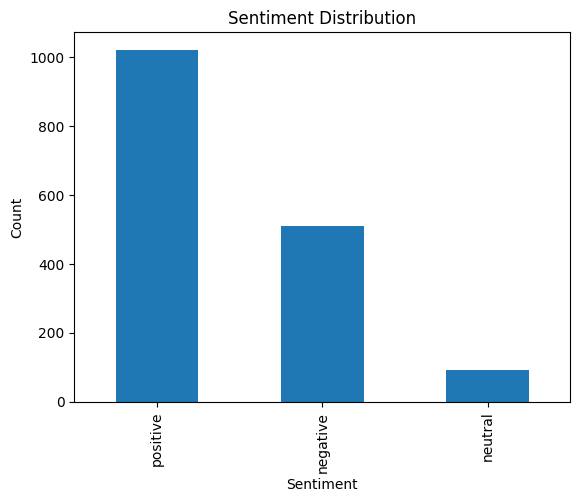

In [8]:
# Bar plot of sentiment labels
cleaned_df["sentiment_label"].value_counts().plot(kind="bar")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


## Sentiment Analysis

### Lexicon-Based Sentiment (TextBlob & VADER)

### 1. TextBlob Lexicon

In [9]:
# Lexicon-based sentiment with TextBlob
# Polarity in [-1, 1], subjectivity in [0, 1]

# Get polarity and subjectivity
cleaned_df["tb_polarity"] = cleaned_df["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
cleaned_df["tb_subjectivity"] = cleaned_df["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Convert polarity → sentiment label
def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

cleaned_df["tb_sentiment"] = cleaned_df["tb_polarity"].apply(polarity_to_label)

# Show output
cleaned_df[["review_text", "rating", "tb_polarity", "tb_subjectivity", "tb_sentiment"]]

,review_text,rating,tb_polarity,tb_subjectivity,tb_sentiment
0,special,5,0.357143,0.571429,positive
1,make user friendly,2,0.375000,0.500000,positive
2,smart app easy use friendly,5,0.340873,0.658730,positive
3,exemplery app bank aps,5,0.000000,0.000000,neutral
4,good,5,0.700000,0.600000,positive
...,...,...,...,...,...
1618,great app others,5,0.800000,0.750000,positive
1619,unreliable send money asap app either laggs do...,1,-0.250000,1.000000,negative
1620,crash glitch crash blame connection crash cras...,1,0.000000,0.000000,neutral
1621,play,5,0.000000,0.000000,neutral


### 2. VADER Lexicon

In [10]:
# Lexicon-based sentiment with VADER
# VADER is optimized for reviews, slang, emojis, and short texts
sia = SentimentIntensityAnalyzer()

def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

# VADER compound score
cleaned_df["vader_compound"] = cleaned_df["review_text"].apply(vader_compound)

# Convert compound score → sentiment label
# Standard VADER rule:
# compound >= 0.05 → positive
# compound <= -0.05 → negative
# otherwise → neutral

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

cleaned_df["vader_sentiment"] = cleaned_df["vader_compound"].apply(vader_label)

# Show output
cleaned_df[["review_text", "rating", "tb_polarity", "vader_compound", "vader_sentiment"]]

,review_text,rating,tb_polarity,vader_compound,vader_sentiment
0,special,5,0.357143,0.4019,positive
1,make user friendly,2,0.375000,0.4939,positive
2,smart app easy use friendly,5,0.340873,0.8316,positive
3,exemplery app bank aps,5,0.000000,0.0000,neutral
4,good,5,0.700000,0.4404,positive
...,...,...,...,...,...
1618,great app others,5,0.800000,0.6249,positive
1619,unreliable send money asap app either laggs do...,1,-0.250000,0.6007,positive
1620,crash glitch crash blame connection crash cras...,1,0.000000,-0.8720,negative
1621,play,5,0.000000,0.3400,positive


#### Visualization of lexicon scores vs rating

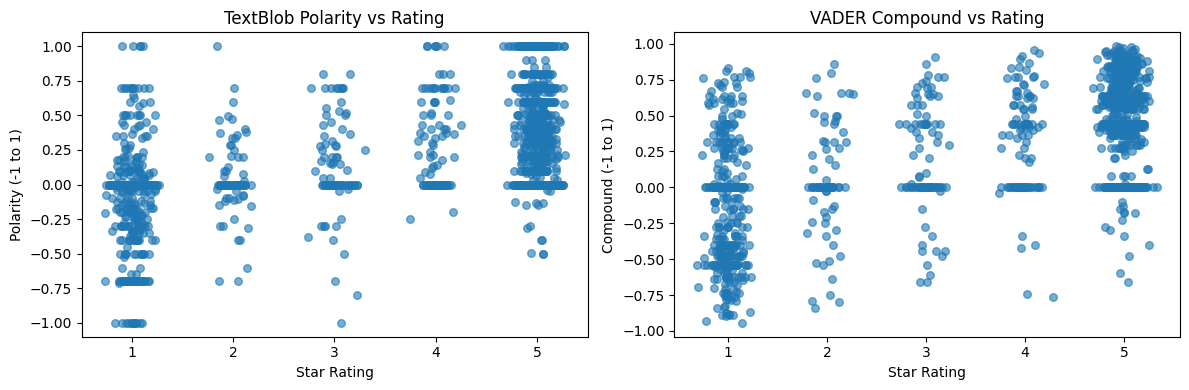

In [11]:
# See how lexicon scores correlate with star rating

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

def add_jitter(arr, scale=0.1):
    return arr + np.random.normal(0, scale, len(arr))

axes[0].scatter(add_jitter(cleaned_df["rating"]), cleaned_df["tb_polarity"], 
               alpha=0.6, s=30)
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Polarity (-1 to 1)")
axes[0].set_xticks([1, 2, 3, 4, 5])

axes[1].scatter(add_jitter(cleaned_df["rating"]), cleaned_df["vader_compound"], 
               alpha=0.6, s=30)
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Star Rating")
axes[1].set_ylabel("Compound (-1 to 1)")
axes[1].set_xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()


### Sentiment Analysis Using DistilBERT

In [12]:
import torch

from transformers import pipeline
# Use the same model for sentiment analysis
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    return_all_scores=True
)

Device set to use mps:0
/Users/elbethelzewdie/Documents/customers-satisfaction-week2/customers-satisfaction-week2/week2/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [13]:
def text_to_sentiment(text, threshold=0.6):
    results = sentiment_analyzer(text)[0]
    pos_score = next(item["score"] for item in results if item["label"] == "POSITIVE")
    neg_score = next(item["score"] for item in results if item["label"] == "NEGATIVE")
    
    # Heuristic for NEUTRAL if model is unsure
    if max(pos_score, neg_score) < threshold:
        return "NEUTRAL", max(pos_score, neg_score)
    
    label = "POSITIVE" if pos_score > neg_score else "NEGATIVE"
    score = max(pos_score, neg_score)
    return label, score


In [14]:
# Add new columns for model-predicted sentiment
cleaned_df["model_sentiment_label"], cleaned_df["model_sentiment_score"] = zip(*cleaned_df["review_text"].apply(text_to_sentiment))


In [15]:
# Normalize both columns
cleaned_df["sentiment_label"] = cleaned_df["sentiment_label"].str.upper()
cleaned_df["model_sentiment_label"] = cleaned_df["model_sentiment_label"].str.upper()
cleaned_df["tb_sentiment"] = cleaned_df["tb_sentiment"].str.upper()
cleaned_df["vader_sentiment"] = cleaned_df["vader_sentiment"].str.upper()

In [16]:
cleaned_df["sentiment_match_distilbert"] = (
    cleaned_df["sentiment_label"] == cleaned_df["model_sentiment_label"]
)

cleaned_df["sentiment_match_textblob"] = (
    cleaned_df["sentiment_label"] == cleaned_df["tb_sentiment"]
)

cleaned_df["sentiment_match_vader"] = (
    cleaned_df["sentiment_label"] == cleaned_df["vader_sentiment"]
)

In [17]:
print(cleaned_df[[
    "review_text",
    "sentiment_label",
    "model_sentiment_label",
    "sentiment_match_distilbert",
    "tb_sentiment",
    "sentiment_match_textblob",
    "vader_sentiment",
    "sentiment_match_vader"
]].head())

                   review_text sentiment_label model_sentiment_label  \
0                      special        POSITIVE              POSITIVE   
1           make user friendly        NEGATIVE              POSITIVE   
2  smart app easy use friendly        POSITIVE              POSITIVE   
3       exemplery app bank aps        POSITIVE              NEGATIVE   
4                         good        POSITIVE              POSITIVE   

   sentiment_match_distilbert tb_sentiment  sentiment_match_textblob  \
0                        True     POSITIVE                      True   
1                       False     POSITIVE                     False   
2                        True     POSITIVE                      True   
3                       False      NEUTRAL                     False   
4                        True     POSITIVE                      True   

  vader_sentiment  sentiment_match_vader  
0        POSITIVE                   True  
1        POSITIVE                  False  
2    

In [18]:
print("DistilBERT match rate:", cleaned_df["sentiment_match_distilbert"].mean())
print("TextBlob match rate:", cleaned_df["sentiment_match_textblob"].mean())
print("VADER match rate:", cleaned_df["sentiment_match_vader"].mean())

DistilBERT match rate: 0.7492298213185459
TextBlob match rate: 0.5218730745532963
VADER match rate: 0.6001232285890327


In [19]:
# Map sentiment labels to numeric values
sentiment_map = {"NEGATIVE": -1, "NEUTRAL": 0, "POSITIVE": 1}

cleaned_df["sentiment_numeric"] = cleaned_df["sentiment_label"].map(sentiment_map)


In [20]:
# Aggregate by bank and rating
agg_df = (
    cleaned_df
    .groupby(["bank_name", "rating"])
    .agg(
        mean_sentiment=("sentiment_numeric", "mean"),
        review_count=("sentiment_numeric", "count")
    )
    .reset_index()
)

print(agg_df)


                      bank_name  rating  mean_sentiment  review_count
0             Bank of Abyssinia       1            -1.0           267
1             Bank of Abyssinia       2            -1.0            29
2             Bank of Abyssinia       3             0.0            37
3             Bank of Abyssinia       4             1.0            25
4             Bank of Abyssinia       5             1.0           216
5   Commercial Bank of Ethiopia       1            -1.0            87
6   Commercial Bank of Ethiopia       2            -1.0            23
7   Commercial Bank of Ethiopia       3             0.0            31
8   Commercial Bank of Ethiopia       4             1.0            57
9   Commercial Bank of Ethiopia       5             1.0           321
10                  Dashen Bank       1            -1.0            81
11                  Dashen Bank       2            -1.0            24
12                  Dashen Bank       3             0.0            23
13                  

In [21]:
columns_to_drop = ['tb_sentiment', 'sentiment_match_textblob', 'vader_sentiment', 'sentiment_match_vader', 'tb_polarity', 'tb_subjectivity', 'vader_compound', 'sentiment_match_distilbert', 'sentiment_numeric', 'sentiment_label']
cleaned_df = cleaned_df.drop(columns=[col for col in columns_to_drop if col in cleaned_df.columns])

# Save the cleaned dataset with only DistilBERT sentiment
cleaned_df.to_csv("/Users/elbethelzewdie/Documents/customers-satisfaction-week2/customers-satisfaction-week2/notebooks/data/processed/cleaned_review_sentiment.csv", index=False)

## Thematic Analysis

### Frequency-Based vs TF-IDF

1. Frequency-based representation (Bag of Words)

In [22]:
# Frequency-based word counts using CountVectorizer

count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(cleaned_df["review_text"])

# Sum counts for each word across all documents
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)
freq_df.head(10)


,word,count
160,app,737
237,bank,223
833,good,188
1901,use,170
1997,work,169
272,best,133
242,banking,117
489,dashen,89
1309,one,88
1085,like,87


Visualize top frequent words

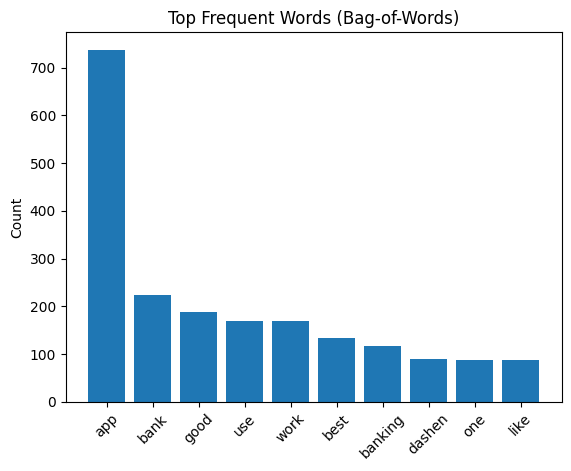

In [23]:
# Plot top frequent words (Frequency-Based)

top_n = 10
top_freq = freq_df.head(top_n)

plt.bar(top_freq["word"], top_freq["count"])
plt.xticks(rotation=45)
plt.title("Top Frequent Words (Bag-of-Words)")
plt.ylabel("Count")
plt.show()


2. TF-IDF representation

TF-IDF (Very Brief Explanation)

TF-IDF shows how important a word is in the dataset.

TF (Term Frequency): how often a word appears.

IDF (Inverse Document Frequency): how unique the word is across all reviews.

TF-IDF = TF × IDF

Higher TF-IDF = more meaningful word.
Lower TF-IDF = common or unimportant word.

✔ What is a good TF-IDF number?

No universal scale — it’s relative.
But generally in small datasets:

> 0.10 = very important

0.05–0.10 = meaningful

< 0.05 = low importance

In [24]:
# TF-IDF representation

tfidf_vec = TfidfVectorizer()
X_tfidf = tfidf_vec.fit_transform(cleaned_df["review_text"])

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head(10)


,word,tfidf
160,app,0.080547
833,good,0.055537
272,best,0.042086
1997,work,0.029161
237,bank,0.027931
1262,nice,0.026062
1901,use,0.025667
232,bad,0.018873
242,banking,0.018407
718,fast,0.018283


Compare raw frequency Vs TF-IDF

In [25]:
# Compare top words by frequency and by TF-IDF

print("Top 10 by raw frequency:")
display(freq_df.head(10))

print("\nTop 10 by TF-IDF (words more unique / informative):")
display(tfidf_df.head(10))

Top 10 by raw frequency:


,word,count
160,app,737
237,bank,223
833,good,188
1901,use,170
1997,work,169
272,best,133
242,banking,117
489,dashen,89
1309,one,88
1085,like,87



Top 10 by TF-IDF (words more unique / informative):


,word,tfidf
160,app,0.080547
833,good,0.055537
272,best,0.042086
1997,work,0.029161
237,bank,0.027931
1262,nice,0.026062
1901,use,0.025667
232,bad,0.018873
242,banking,0.018407
718,fast,0.018283


### N-Gram Keyword Extraction

In [26]:
# N-Gram Keyword Extraction (Bigrams)
vectorizer = CountVectorizer(
    ngram_range=(2, 2),   
)

# 2. Fit and transform the review_text column
X = vectorizer.fit_transform(df['review_text'])

# 3. Sum occurrences of each bigram across all reviews
bigram_counts = X.sum(axis=0)

# 4. Map counts to bigram phrases
bigram_freq = [(bigram, bigram_counts[0, idx]) for bigram, idx in vectorizer.vocabulary_.items()]

# 5. Sort by frequency descending
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# 6. Show top 10 bigrams
top_10_bigrams = bigram_freq[:10]
print("Top 10 bigram phrases:")
for bigram, count in top_10_bigrams:
    print(f"{bigram}: {count}")

Top 10 bigram phrases:
mobile banking: 56
dashen bank: 50
banking app: 47
app ever: 45
best app: 40
super app: 39
easy use: 36
good app: 36
bad app: 31
doesnt work: 31


### Topic Modeling (LDA)

In [27]:
# Tokenize text (very simple split for demo)
cleaned_df["tokens"] = cleaned_df["review_text"].str.split()

# Create dictionary and corpus for LDA
dictionary = Dictionary(cleaned_df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in cleaned_df["tokens"]]

In [28]:
cleaned_df[["review_text", "tokens"]].head()

,review_text,tokens
0,special,[special]
1,make user friendly,"[make, user, friendly]"
2,smart app easy use friendly,"[smart, app, easy, use, friendly]"
3,exemplery app bank aps,"[exemplery, app, bank, aps]"
4,good,[good]


In [29]:

# Create 
dictionary = Dictionary(cleaned_df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in cleaned_df["tokens"]]


lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,
    passes=10,
    random_state=42
)


In [30]:
topics = lda_model.show_topics(num_topics=2, num_words=10, formatted=False)

for i, topic in topics:
    print(f"\n--- Topic {i+1} ---")
    for word, weight in topic:
        print(f"{word:15s}  weight={weight:.4f}")


--- Topic 1 ---
app              weight=0.0658
good             weight=0.0211
update           weight=0.0133
use              weight=0.0122
work             weight=0.0109
banking          weight=0.0100
bad              weight=0.0098
please           weight=0.0094
like             weight=0.0093
cant             weight=0.0089

--- Topic 2 ---
app              weight=0.0538
bank             weight=0.0327
best             weight=0.0212
work             weight=0.0169
use              weight=0.0156
dashen           weight=0.0144
one              weight=0.0132
application      weight=0.0126
service          weight=0.0115
nice             weight=0.0100


Part-of-Speech Tagging (Noun Extraction)

In [31]:
# extract nouns 
nlp = spacy.load("en_core_web_sm")

def extract_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == "NOUN"]

cleaned_df["nouns"] = cleaned_df["review_text"].apply(extract_nouns)
cleaned_df[["review_text", "nouns"]]

,review_text,nouns
0,special,[]
1,make user friendly,[user]
2,smart app easy use friendly,"[app, use]"
3,exemplery app bank aps,"[exemplery, bank, aps]"
4,good,[]
...,...,...
1618,great app others,"[app, others]"
1619,unreliable send money asap app either laggs do...,"[money, laggs, work]"
1620,crash glitch crash blame connection crash cras...,"[crash, blame, connection, crash, crash]"
1621,play,[]


### Define Themes and Keyword Mapping

In [37]:
# Predefined themes and associated keywords/bigrams
THEME_KEYWORDS = {
    "Account Access Issues": ["login issue", "password reset", "account blocked", "cannot login", "authentication failure"],
    "Transaction Performance": ["transfer failed", "payment error", "slow transfer", "pending transaction", "transaction delay"],
    "User Interface & Experience": ["user interface", "app crash", "navigation problem", "UI design", "app freeze"],
    "Customer Support": ["customer support", "call center", "support response", "help desk", "agent response"],
    "Feature Requests": ["feature request", "add feature", "new feature", "support for", "would like"]
}



In [40]:
def assign_themes_to_bigrams(bigram_list):
    """
    Map a list of bigrams to their corresponding themes.
    Returns a list of themes.
    """
    matched_themes = set()
    for bigram in bigram_list:
        for theme, keywords in THEME_KEYWORDS.items():
            if bigram.lower() in keywords:
                matched_themes.add(theme)
    # If no match found, assign "Other"
    return list(matched_themes) if matched_themes else ["Other"]



In [44]:
def extract_bigrams(text):
    tokens = text.split()
    bigrams = [" ".join([tokens[i], tokens[i+1]]) for i in range(len(tokens)-1)]
    return bigrams

cleaned_df["keywords"] = cleaned_df["review_text"].apply(extract_bigrams)


In [46]:
# Create a new column for assigned themes
cleaned_df["themes"] = cleaned_df["keywords"].apply(assign_themes_to_bigrams)

# Optional: Inspect first rows
cleaned_df[["bank_name", "keywords", "themes"]].head(10)

,bank_name,keywords,themes
0,Commercial Bank of Ethiopia,[],[Other]
1,Commercial Bank of Ethiopia,"[make user, user friendly]",[Other]
2,Dashen Bank,"[smart app, app easy, easy use, use friendly]",[Other]
3,Dashen Bank,"[exemplery app, app bank, bank aps]",[Other]
4,Dashen Bank,[],[Other]
5,Bank of Abyssinia,[],[Other]
6,Bank of Abyssinia,[],[Other]
7,Dashen Bank,[amaze app],[Other]
8,Bank of Abyssinia,[],[Other]
9,Commercial Bank of Ethiopia,"[maaliif daddafee, daddafee install, install g...",[Other]


In [47]:
theme_summary = (
    cleaned_df.explode("themes")  # explode list of themes into rows
      .groupby(["bank_name", "themes"])
      .size()
      .reset_index(name="count")
      .sort_values(["bank_name", "count"], ascending=[True, False])
)

print(theme_summary)


                      bank_name                       themes  count
1             Bank of Abyssinia                        Other    568
2             Bank of Abyssinia  User Interface & Experience      5
0             Bank of Abyssinia             Feature Requests      1
5   Commercial Bank of Ethiopia                        Other    513
4   Commercial Bank of Ethiopia             Feature Requests      3
3   Commercial Bank of Ethiopia             Customer Support      1
6   Commercial Bank of Ethiopia      Transaction Performance      1
7   Commercial Bank of Ethiopia  User Interface & Experience      1
10                  Dashen Bank                        Other    522
11                  Dashen Bank  User Interface & Experience      6
8                   Dashen Bank             Customer Support      1
9                   Dashen Bank             Feature Requests      1
